In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
#Part A:定义
#1.定义batch大小

#2.定义神经网络框架：输入，输出，中间结果，参数（权值），激活函数

batch_size = 100 

original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

#2.1 定义encoder网络：输入x,中间结果h,输出采样z_mean 和 z_log_var
#keras 当前 layers的值=当前dense（lambda） layer的值（weight）*上一层的input
x = Input(shape=(original_dim,))#输入x,输入层784个结点
h = Dense(intermediate_dim, activation='relu')(x)#中间结果h，隐藏层256个结点，激活函数relu
z_mean = Dense(latent_dim)(h)#隐变量输出层1有2 个结点
z_log_var = Dense(latent_dim)(h)#隐变量输出层2有2个结点
'''
##keras.layers.Dense(units, 
				  activation=None, 
				  use_bias=True, 
				  kernel_initializer='glorot_uniform', 
				  bias_initializer='zeros', 
				  kernel_regularizer=None, 
				  bias_regularizer=None, 
			      activity_regularizer=None, 
				  kernel_constraint=None, 
				  bias_constraint=None)
参数说明如下：
units:
该层有几个神经元
activation:
该层使用的激活函数
use_bias:
是否添加偏置项
kernel_initializer:
权重初始化方法
bias_initializer:
偏置值初始化方法
kernel_regularizer:
权重规范化函数
bias_regularizer:
偏置值规范化方法
activity_regularizer:
输出的规范化方法
kernel_constraint:
权重变化限制函数
bias_constraint:
偏置值变化限制函数
'''

In [3]:
#2.2：定义隐变量层lambda
#定义隐变量层：输入z_mean,和z_log_var,输出是z，没有weight，没有参数需要学习，只是通过一个函数做一个变换，所以用Lambda layer

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])#输入是z_mean和z_log_var，输出是z

'''
keras.layers.core.Lambda(function, output_shape=None, mask=None, arguments=None)
如果你只是想对流经该层的数据做个变换，而这个变换本身没有什么需要学习的参数，那么直接用Lambda Layer是最合适的了。
Lambda函数接受两个参数，第一个是输入张量对输出张量的映射函数，第二个是输入的shape对输出的shape的映射函数。

参数
function：要实现的函数，该函数仅接受一个变量，即上一层的输出

output_shape：函数应该返回的值的shape，可以是一个tuple，也可以是一个根据输入shape计算输出shape的函数

mask: 掩膜

arguments：可选，字典，用来记录向函数中传递的其他关键字参数

'''
#2.3 定义decoder网络，输入z ,中间结果h,输出采样z_mean 和 z_log_var
# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')#隐藏层
decoder_mean = Dense(original_dim, activation='sigmoid')#输出层

h_decoded = decoder_h(z)#中间值
x_decoded_mean = decoder_mean(h_decoded)#输出值

#2.4 定义函数式模型接口API:Model ,定义Model内相关参数（loss等）
# instantiate VAE model
vae = Model(x, x_decoded_mean)
#model = Model(inputs=[a1, a2], outputs=[b1, b3, b3])

# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) #KL+交叉熵
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss) #复杂损失函数所以不在compile声明，而使用add_loss
vae.compile(optimizer='rmsprop') #用于配置训练模型。

#compile(self, optimizer, loss, metrics=None, loss_weights=None, sample_weight_mode=None, 
#weighted_metrics=None, target_tensors=None)

vae.summary() #model.summary()：打印出模型概况，它实际调用的是keras.utils.print_summary
#参数的个数计算：
#784*256w+256=200960
#256*2+2=514
#2*256+256=768(虽然z是1个值但是outshape定义为2维的所以隐变量z是2维)
#256*784+784=201488

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

In [13]:
#Part B:生成数据集
# train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()
#返回值
#两个Tuple,(X_train, y_train), (X_test, y_test)
'''
X_train和X_test：是形如（nb_samples, 28, 28）的灰度图片数据，数据类型是无符号8位整形（uint8）0-255
y_train和y_test：是形如（nb_samples,）标签数据，标签的范围是0~9
'''
#print(x_train[0])#打印第一张图片数据
#print( _[0])#第一个标签数据
x_train = x_train.astype('float32') / 255.#数据预处理归一化
#print(x_train[0])#打印第一张图片数据
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))#改变shape从(6000,28,28)到(6000,784)
print(x_train[0])
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
 - 10s - loss: 191.0801 - val_loss: 171.8919
Epoch 2/50
 - 9s - loss: 169.6191 - val_loss: 167.8284
Epoch 3/50
 - 8s - loss: 166.2477 - val_loss: 164.9255
Epoch 4/50
 - 9s - loss: 164.1777 - val_loss: 163.5063
Epoch 5/50
 - 9s - loss: 162.6645 - val_loss: 162.2579
Epoch 6/50
 - 9s - loss: 161.3758 - val_loss: 160.9785
Epoch 7/50
 - 9s - loss: 160.2123 - val_loss: 159.8076
Epoch 8/50
 - 8s - loss: 159.1821 - val_loss: 159.1061
Epoch 9/50
 - 9s - loss: 158.3450 - val_loss: 158.7271
Epoch 10/50
 - 8s - loss: 157.5899 - val_loss: 157.7460
Epoch 11/50
 - 9s - loss: 156.9995 - val_loss: 157.1616
Epoch 12/50
 - 9s - loss: 156.4250 - val_loss: 156.6522
Epoch 13/50
 - 9s - loss: 155.9274 - val_loss: 156.3111
Epoch 14/50
 - 9s - loss: 155.5097 - val_loss: 155.7963
Epoch 15/50
 - 9s - loss: 155.1177 - val_loss: 155.6183
Epoch 16/50
 - 9s - loss: 154.7402 - val_loss: 155.2961
Epoch 17/50
 - 9s - loss: 154.4278 - val_loss: 155.0555
Epoch 

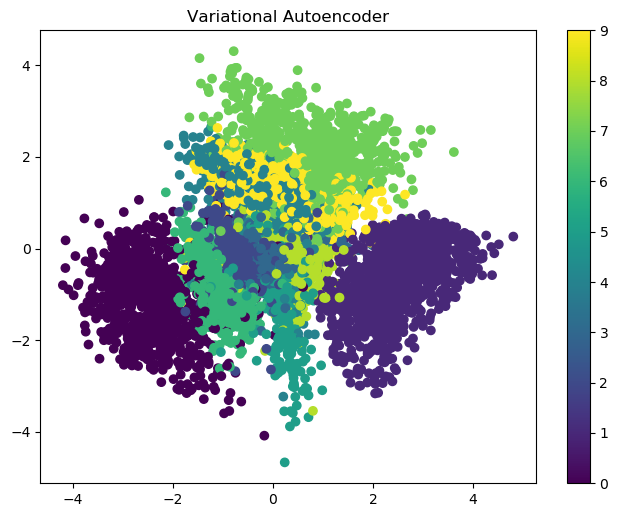

In [5]:
#training
vae.fit(x_train,#算输出和输入分布的差异所以没有y
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
        validation_data=(x_test, None))
#fit(self, x, y, batch_size=32, nb_epoch=10, verbose=1, callbacks=[], validation_split=0.0, 
#validation_data=None, shuffle=True, class_weight=None, sample_weight=None)
'''
x：输入数据。如果模型只有一个输入，那么x的类型是numpy array，
如果模型有多个输入，那么x的类型应当为list，list的元素是对应于各个输入的numpy array。
如果模型的每个输入都有名字，则可以传入一个字典，将输入名与其输入数据对应起来。

y：标签，numpy array。如果模型有多个输出，可以传入一个numpy array的list。如果模型的输出拥有名字，
则可以传入一个字典，将输出名与其标签对应起来。

batch_size：整数，指定进行梯度下降时每个batch包含的样本数。训练时一个batch的样本会被计算一次梯度下降，使目标函数优化一步。

nb_epoch：整数，训练的轮数，训练数据将会被遍历nb_epoch次。Keras中nb开头的变量均为"number of"的意思

verbose：日志显示，0为不在标准输出流输出日志信息，1为输出进度条记录，2为每个epoch输出一行记录

callbacks：list，其中的元素是keras.callbacks.Callback的对象。

这个list中的回调函数将会在训练过程中的适当时机被调用，参考回调函数

validation_split：0~1之间的浮点数，用来指定训练集的一定比例数据作为验证集。验证集将不参与训练，
并在每个epoch结束后测试的模型的指标，如损失函数、精确度等。

validation_data：形式为（X，y）或（X，y，sample_weights）的tuple，是指定的验证集。此参数将覆盖validation_spilt。

shuffle：布尔值，表示是否在训练过程中每个epoch前随机打乱输入样本的顺序。

class_weight：字典，将不同的类别映射为不同的权值，该参数用来在训练过程中调整损失函数（只能用于训练）。
该参数在处理非平衡的训练数据（某些类的训练样本数很少）时，可以使得损失函数对样本数不足的数据更加关注。

sample_weight：权值的numpy array，用于在训练时调整损失函数（仅用于训练）。
可以传递一个1D的与样本等长的向量用于对样本进行1对1的加权，或者在面对时序数据时，
传递一个的形式为（samples，sequence_length）的矩阵来为每个时间步上的样本赋不同的权。
这种情况下请确定在编译模型时添加了sample_weight_mode='temporal'。
'''

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)#输入x，输出z_mean的网络

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)#100个batch的输出z_mean，z_mean是一个二维的vector
#predict(self, x, batch_size=32, verbose=0),按batch获得输入数据对应的输出，函数的返回值是预测值的numpy array


plt.figure(figsize=(8, 6), dpi=100)#Create a new figure.


plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
#冒号代表全选，0和1代表z_mean 二维vector的第0维和第1维
plt.title('Variational Autoencoder')
plt.colorbar()
plt.show()

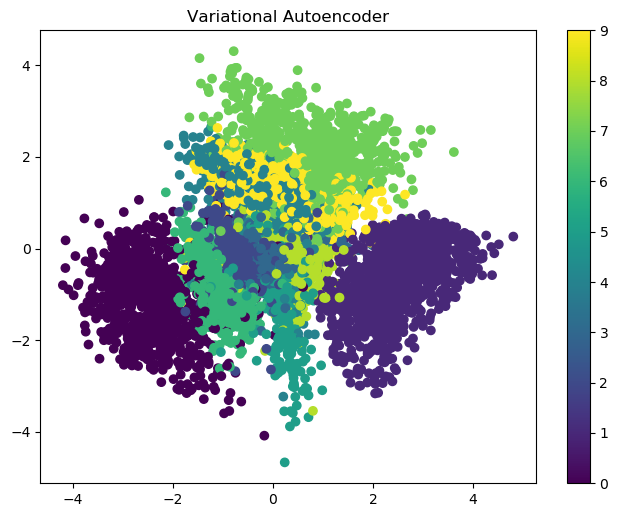

In [16]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)#100个batch的输出z_mean，z_mean是一个二维的vector
#predict(self, x, batch_size=32, verbose=0),按batch获得输入数据对应的输出，函数的返回值是预测值的numpy array


plt.figure(figsize=(8, 6), dpi=100)#Create a new figure.


plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
#冒号代表全选，0和1代表z_mean 二维vector的第0维和第1维，c=y_test:不同的lable的点用不同的颜色标记
plt.title('Variational Autoencoder')
plt.colorbar()
plt.show()

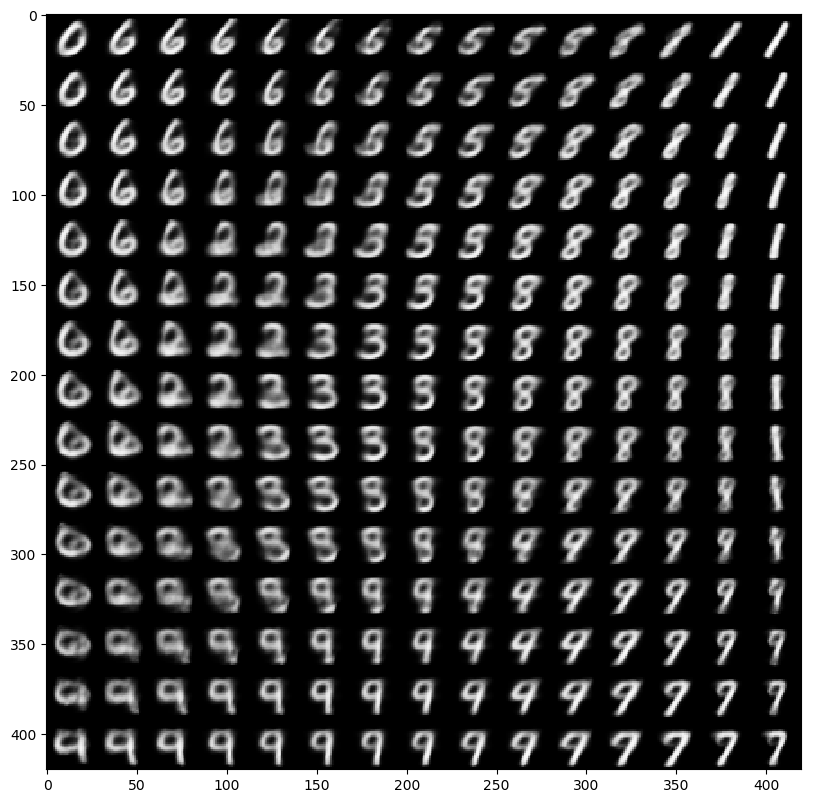

In [6]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10), dpi=100)
plt.imshow(figure, cmap='Greys_r')
plt.show()